In [153]:
import numpy as np
import matplotlib.pyplot as plt

asd_file = "asd.txt"
asd_columns=["freq","strain"]
gw_columns=["time", "h_plus", "h_cross", "h_H1", "h_L1"]

Important function definitions

In [154]:
def read_file(filename,columns):
    # MAKE MORE EFFICIENTTTT
    file_dict={}
    f = open(filename,"r") 
    f_read=f.readlines()
    for line in f_read[1:]:
        split_line=line.split()
        for i in range(len(columns)):
            try:
                file_dict[columns[i]].append(float(split_line[i]))
            except:
                file_dict[columns[i]]=[float(split_line[i])]
                
    for i in range(len(columns)):
        file_dict[columns[i]]=np.array(file_dict[columns[i]])
    return file_dict


def compute_SNR(waveform_1,waveform_2,asd_func,time,fs):
    '''
    Input: 2 complex wavesforms, 1 time vector
    '''
    # taking fft
    dt=time[1]-time[0]
    waveform_fft_1 = np.fft.fft(waveform_1) * dt
    waveform_fft_2 = np.fft.fft(waveform_2) * dt
    waveform_freq = np.fft.fftfreq(time.size) * fs

    # asd data starts at a higher freq
    freqs_cut = waveform_freq[np.where(waveform_freq>=9.)]
    waveform_fft_1_cut = waveform_fft_1[np.where(waveform_freq>=9.)]
    waveform_fft_2_cut = waveform_fft_2[np.where(waveform_freq>=9.)]

    SNR_integrand = 4*(np.absolute(np.conj(waveform_fft_1_cut)*waveform_fft_2_cut)/(asd_func(freqs_cut))**2)
    SNR_mean= np.sqrt(np.trapz(SNR_integrand, freqs_cut))
    
    return SNR_mean


Reading in the template files and choosing which one to work with

In [155]:
# reads in the asd and waveform files
asd_data=read_file(asd_file,asd_columns)
GW150914_median_data=read_file("waveforms/GW150914_median.txt",gw_columns)
#GW150914_aligned_data=read_file("waveforms/GW151226_aligned.txt",gw_columns)
#LVT151012_aligned_data=read_file("waveforms/LVT151012_aligned.txt",gw_columns)

# asd file isn't the same length as the waveform templates; interpolate
asd_func = interpolate.interp1d(asd_data["freq"], asd_data["strain"])

wave_event_data=GW150914_median_data
#wave_event_data=GW150914_aligned_data
#wave_event_data=LVT151012_aligned_data

Generating f_GW

In [156]:
# modified slightly from the ligo code

#complex is easier to deal with
waveform = wave_event_data["h_plus"]+1.j*wave_event_data["h_cross"]
dt = wave_event_data["time"][1]-wave_event_data["time"][0]
fs = 4096 

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.absolute(np.unwrap(np.angle(waveform)))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
iffix = np.where(np.absolute(waveform) < np.absolute(waveform).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

Smoothening method #1

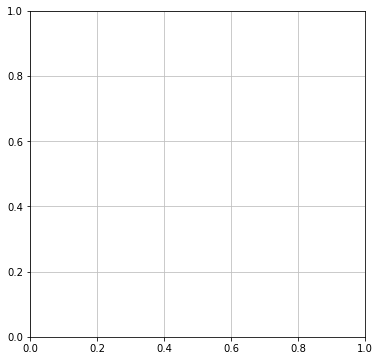

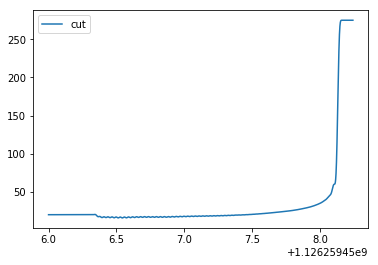

In [157]:
# smoothening (ARBITRARY)
# is this method ok -- check with alan

from scipy.signal import butter, filtfilt
cutoff = 30

# for smoothening -- IS THIS METHOD OK???

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

t_c=np.where(fGW==max(fGW))[0][0]
fGW_smooth = butter_lowpass_filtfilt(fGW[:t_c], cutoff, fs)
fGW_smooth = np.lib.pad(fGW_smooth, (0,wave_event_data["time"].size-t_c), 'edge')


plt.figure()
#plt.plot(wave_event_data["time"],fGW,label="orig")
plt.plot(wave_event_data["time"],fGW_smooth,label="cut")
#plt.xlim(7.5+1.12625945e9, 8.3+1.12625945e9)
plt.legend(loc = 'upper left')
plt.show()

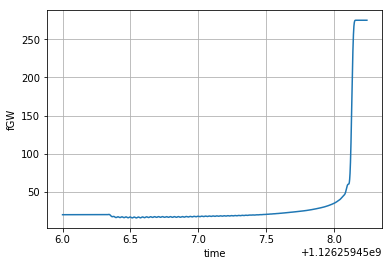

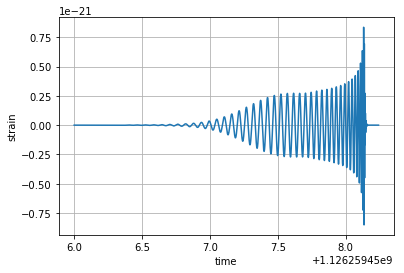

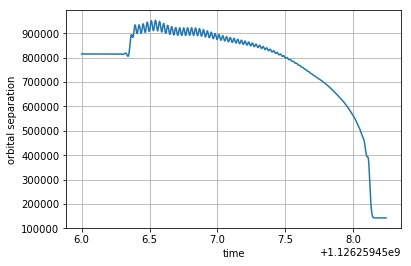

In [158]:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg
M_tot = 65.                           #  in solar masses; choose based on the template event

# calculating orbital separation
r = (G*M_tot*MSol/(4*(np.pi**2)*fGW_smooth**2))**(1./3)

plt.figure()
plt.plot(wave_event_data["time"],fGW_smooth)
plt.grid()
plt.xlabel('time')
plt.ylabel('fGW')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()

plt.figure()
plt.plot(wave_event_data["time"],wave_event_data["h_L1"])
plt.grid()
plt.xlabel('time')
plt.ylabel('strain')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()

plt.figure()
plt.plot(wave_event_data["time"],r)
plt.grid()
plt.xlabel('time')
plt.ylabel('orbital separation')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()

Waveform modulation

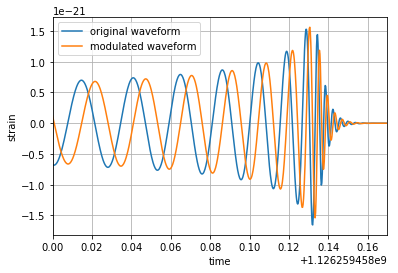

In [159]:
# now onto the lambda factor 

lamda_amp = .08
lamda_freq = 1.6
exp_arg = (G*M_tot*MSol)/(r*clight**2)


waveform = wave_event_data["h_plus"]+1.j*wave_event_data["h_cross"]
time =wave_event_data["time"]

def apply_modulation(waveform,lamda_amp,lamda_freq):
    waveform_fft = np.fft.fft(waveform)
    mult_factor=np.exp(lamda_amp+1.j*lamda_freq)
    mod_waveform_fft=waveform_fft*mult_factor
    mod_waveform=np.fft.ifft(mod_waveform_fft)
    
    return mod_waveform

mod_waveform=apply_modulation(waveform,lamda_amp,lamda_freq)


plt.figure()
plt.plot(wave_event_data["time"],waveform,label="original waveform")
plt.plot(wave_event_data["time"],mod_waveform,label="modulated waveform")
plt.grid()
plt.xlim(8.0+1.12625945e9, 8.17+1.12625945e9)
plt.xlabel('time')
plt.ylabel('strain')
plt.legend(loc='upper left')
plt.show()


In [161]:
# SNR, grid method IM TAKING OUT THE SCALING!!!

#import pymc as mc

lamda_amp = .8
lamda_freq = .6



amp_vals=np.linspace(0,1,11)
freq_vals=np.linspace(0,1,11)

waveform = wave_event_data["h_plus"]+1.j*wave_event_data["h_cross"]
waveform_2 =apply_modulation(waveform,lamda_amp,lamda_freq)

vals = []
for amp in amp_vals:
    amp_array=[]
    for freq in freq_vals:
        waveform_1 = apply_modulation(waveform,amp,freq)
        SNR = compute_SNR(waveform_1,waveform_2,asd_func,wave_event_data["time"],fs)
        amp_array.append(SNR)
    vals.append(amp_array)
    
print vals
        
    







[[14.121953846527719, 14.121953846527715, 14.121953846527724, 14.121953846527727, 14.121953846527708, 14.121953846527719, 14.12195384652772, 14.12195384652772, 14.121953846527726, 14.121953846527726, 14.121953846527713], [14.846001903210805, 14.846001903210812, 14.846001903210796, 14.846001903210805, 14.846001903210809, 14.846001903210803, 14.846001903210798, 14.846001903210805, 14.846001903210807, 14.846001903210809, 14.8460019032108], [15.607172697588963, 15.607172697588965, 15.607172697588975, 15.607172697588972, 15.607172697588952, 15.607172697588958, 15.607172697588968, 15.607172697588961, 15.607172697588947, 15.607172697588965, 15.607172697588974], [16.407369553124305, 16.407369553124301, 16.407369553124305, 16.407369553124294, 16.407369553124308, 16.407369553124305, 16.407369553124298, 16.407369553124298, 16.407369553124298, 16.407369553124305, 16.407369553124294], [17.248593378759566, 17.24859337875958, 17.24859337875958, 17.248593378759576, 17.248593378759576, 17.2485933787595

NameError: name 'args' is not defined

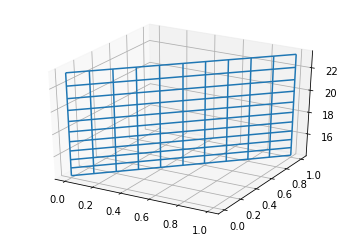

In [165]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(amp_vals, freq_vals, vals)
#ax.scatter(1,2,3)
plt.show()

                     